In [15]:
%run notebook.config.ipy

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
set database db: ../csvdb
set database anndb: /gfs/mirror/annotations/mm10_ensembl78/csvdb
set database ipydb: csvdb


In [16]:
count_table_filtered = DB.fetch_DataFrame('''select * from count_table_filtered''', ipydb)

**Brennecke and Heiseler noise analysis**
http://www.nature.com/nmeth/journal/v10/n11/extref/nmeth.2645-S2.pdf

In [17]:
%%R
#additional libraries
library(matrixStats)
library(DESeq2)
library(genefilter)
library(statmod)

*(1) Calcuation of size factors*

In [18]:
%%R -i count_table_filtered
require(DESeq2)
#print(head(count_table))

dataMouse <- count_table_filtered
rownames(dataMouse) <- dataMouse$gene_id
dataMouse$gene_id <- NULL


geneTypes <- factor( c( ENSM="ENSM", ERCC="ERCC" )[
  substr( rownames(dataMouse), 1, 4 ) ] )

#2. calculate normalisation for counts
countsMmus <- dataMouse[ which( geneTypes=="ENSM" ), ]
countsERCC <- dataMouse[ which( geneTypes=="ERCC" ), ]
#lengthsMmus <- dataMouse[ which( geneTypes=="ENSM" ), 1 ]
#lengthsERCC <- dataMouse[ which( geneTypes=="ERCC" ), 1 ]

sfMmus <- estimateSizeFactorsForMatrix( countsMmus )
sfERCC <- estimateSizeFactorsForMatrix( countsERCC )

In [19]:
%%R
#print(tail(rownames(dataMouse)))
rbind(sfERCC, sfMmus)

          index Scid.recons.p2.A.1 Scid.recons.p2.A.2 Scid.recons.p2.A.3
sfERCC 18.60890          0.2964068          0.6724569          0.2330867
sfMmus 23.82908          0.5159793          1.2156015          1.2560887
       Scid.recons.p2.A.4 Scid.recons.p2.A.5 Scid.recons.p2.A.6
sfERCC          0.8460965          0.6459079          0.6575731
sfMmus          0.6196086          0.8873627          0.8459765
       Scid.recons.p2.A.7 Scid.recons.p2.A.11 Scid.recons.p2.A.12
sfERCC           1.578221           3.6248161            1.626226
sfMmus           2.320326           0.5202626            2.310159
       Scid.recons.p2.B.2 Scid.recons.p2.B.3 Scid.recons.p2.B.5
sfERCC           1.395629          0.9076484           1.660601
sfMmus           1.219161          2.0278077           1.021641
       Scid.recons.p2.B.7 Scid.recons.p2.B.9 Scid.recons.p2.B.10
sfERCC          0.9694452          1.3588822           0.5629712
sfMmus          1.9355318          0.4755612           0.3812385
    

*(2) Normalisation of spikes and biological genes*

In [20]:
%%R
#normalise read counts
nCountsERCC <- t( t(countsERCC) / sfERCC )
nCountsMmus <- t( t(countsMmus) / sfMmus )

*(3) Calculation of sample moments*

In [21]:
%%R
meansERCC <- rowMeans( nCountsERCC )
varsERCC <- rowVars( nCountsERCC )
cv2ERCC <- varsERCC / meansERCC^2
meansMmus <- rowMeans( nCountsMmus )
varsMmus <- rowVars( nCountsMmus )
cv2Mmus <- varsMmus / meansMmus^2

*(4) Fit technical noise*

In [61]:
%%R
minMeanForFitA <- unname( quantile( meansERCC[ which( cv2ERCC > .3 ) ], 0.8 ) ) #default 0.3, 0.8
useForFitA <- meansERCC >= minMeanForFitA
minMeanForFitA
table( useForFitA )

useForFitA
FALSE  TRUE 
   57    35 


In [62]:
%%R
fitA <- glmgam.fit( cbind( a0 = 1, a1tilde = 1/meansERCC[useForFitA] ),
 cv2ERCC[useForFitA] )

Variance explained by fit

In [63]:
%%R
residualA <- var( log( fitted.values(fitA) ) - log( cv2ERCC[useForFitA] ) )
totalA <- var( log( cv2ERCC[useForFitA] ) )
1 - residualA / totalA

[1] 0.9149221


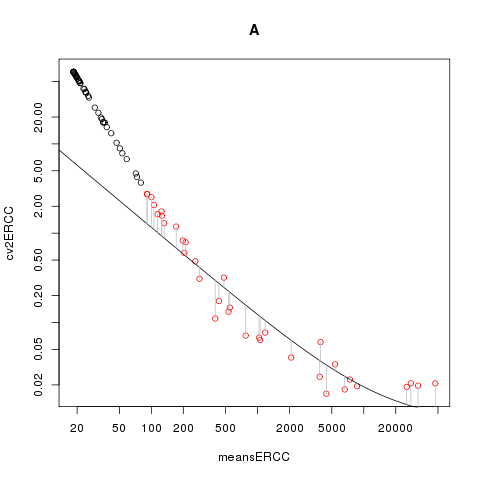

In [64]:
%%R
plot( meansERCC, cv2ERCC, log="xy", col=1+useForFitA, main="A" )
xg <- 10^seq( -3, 5, length.out=100 )
lines( xg, coefficients(fitA)["a0"] + coefficients(fitA)["a1tilde"]/xg )
segments( meansERCC[useForFitA], cv2ERCC[useForFitA],
 meansERCC[useForFitA], fitA$fitted.values, col="gray" )

*(5) Test for high variance*

In [65]:
%%R
minBiolDisp <- .5^2
xi <- mean( 1 / sfERCC )
m <- ncol(countsMmus)
psia1thetaA <- mean( 1 / sfERCC ) +
 ( coefficients(fitA)["a1tilde"] - xi ) * mean( sfERCC / sfMmus )
cv2thA <- coefficients(fitA)["a0"] + minBiolDisp + coefficients(fitA)["a0"] * minBiolDisp

testDenomA <- ( meansMmus * psia1thetaA + meansMmus^2 * cv2thA ) / ( 1 + cv2thA/m )
pA <- 1 - pchisq( varsMmus * (m-1) / testDenomA, m-1 )
padjA <- p.adjust( pA, "BH" )
table( padjA < .1 )



FALSE  TRUE 
 6989 15030 


*(6) Plot result*

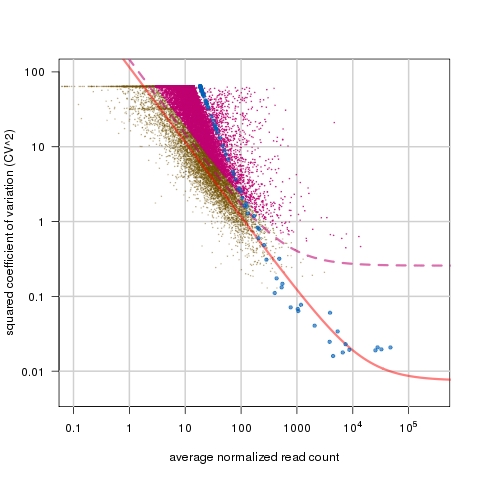

In [66]:
%%R

plot( NULL, xaxt="n", yaxt="n",
 log="xy", xlim = c( 1e-1, 3e5 ), ylim = c( .005, 100 ),
 xlab = "average normalized read count", ylab = "squared coefficient of variation (CV^2)" )
axis( 1, 10^(-1:5), c( "0.1", "1", "10", "100", "1000",
 expression(10^4), expression(10^5) ) )
axis( 2, 10^(-2:2), c( "0.01", "0.1", "1", "10" ,"100"), las=2 )
abline( h=10^(-2:1), v=10^(-1:5), col="#D0D0D0", lwd=2 )
# Plot the plant genes, use a different color if they are highly variable
points( meansMmus, cv2Mmus, pch=20, cex=.2,
 col = ifelse( padjA < .1, "#C0007090", "#70500040" ) )
# Add the technical noise fit, as before
xg <- 10^seq( -2, 6, length.out=1000 )

lines( xg, coefficients(fitA)["a1tilde"] / xg + coefficients(fitA)["a0"], col="#FF000080", lwd=3 )
# Add a curve showing the expectation for the chosen biological CV^2 thershold
lines( xg, psia1thetaA/xg + coefficients(fitA)["a0"] + minBiolDisp,
 lty="dashed", col="#C0007090", lwd=3 )
# Add the normalised ERCC points
points( meansERCC, cv2ERCC, pch=20, cex=1, col="#0060B8A0" )

In [ ]:
# Note that the applied default model fails to fit this data!!